This script reads in the original "tracks" (already homogenzied to 16 bit, 41100 Hz, mono - done using the *fix_wavs* method of *warbleR* package in R) and corresponding selection tables (Raven). 

Clipped tracks are discarded and the remaining files noise reduced. Clips are then saved as wav files from valid selections (i.e. call type label does not include "unusable", etc.). 

File naming convention is: *\<Track ID\>\_\<Clip ID\>\_\<Goose ID\>\_\<call type\>.wav*

In [119]:
import glob
from pathlib import Path
import pandas as pd
import numpy as np

import librosa
import noisereduce as nr
from scipy.io import wavfile
from maad.sound import spectral_snr
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
N_FFT = 512
PADDING_SECS = 0

##### Consolidate information on tracks and selection files

In [121]:
DATAPATH = "/Users/lenagies/Desktop/Master/Thesis/geese/data"
OUTPATH = "/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections"
MASTERFILE_NAME = "LATEST_greylag_goose_call_masterfile_cleaned.xlsx"

track_paths = glob.glob(DATAPATH+"/tracks/homogenized_sound_files/*.wav")
track_paths += glob.glob(DATAPATH+"/tracks/homogenized_sound_files/*.WAV")
track_paths += glob.glob(DATAPATH+"/tracks/Jonas/homogenized_sound_files/*.WAV")
track_paths += glob.glob(DATAPATH+"/tracks/Jonas/homogenized_sound_files/*.wav")
track_paths += glob.glob(DATAPATH+"/tracks/Lena/homogenized_sound_files/*.WAV")
track_paths += glob.glob(DATAPATH+"/tracks/Lena/homogenized_sound_files/*.wav")
selection_paths = glob.glob(DATAPATH+"/selections/*.txt")
selection_paths += glob.glob(DATAPATH+"/selections/Jonas/*.txt")
selection_paths += glob.glob(DATAPATH+"/selections/Lena/*.txt")

Keep only filepaths for wavs with existing selection table and discard clipped tracks. These are listed in */Users/lenagies/Desktop/Master/Thesis/geese/data/clipped_files.rtf* which was created with the following sox commands:

```
find . | while read LINE
do
 sox "$LINE" -n --norm -R gain 0 2>&1 | grep clipped && echo "$LINE" 
done
```

In [122]:
track_paths = [track_path for track_path in track_paths if (track_path.split("/")[-1].split(".")[0]) in '\n'.join(selection_paths)]
print(len(track_paths))

672


In [123]:
clipped_files = []
f = open("/Users/lenagies/Desktop/Master/Thesis/geese/data/clipped_files.rtf", "r")
for line in f:
  if line.startswith("sox") and "1 samples" in line:
    f.readline()
  if line.startswith("./"):
    clipped_files.append(line.split("/")[-1].replace("\\\n", ""))

print(len(clipped_files))

70


In [124]:
track_paths = [track_path for track_path in track_paths if not (track_path.split("/")[-1].split(".")[0]) in '\n'.join(clipped_files)]
print(len(track_paths))

641


Open Masterfile into dataframe and only keep rows for remaining tracks

In [125]:
master_df = pd.read_excel(Path(DATAPATH, MASTERFILE_NAME))
master_df = master_df[master_df['Track ID'].isin([(track_path.split("/")[-1].split(".")[0]) for track_path in track_paths])]
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8466 entries, 23 to 12973
Data columns (total 24 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Track ID                                                           8466 non-null   object 
 1   Clip ID                                                            7847 non-null   object 
 2   Bout Call ID * formerly Neckband Nr; but no single entry was made  2 non-null      object 
 3   Goose ID                                                           8466 non-null   object 
 4   upper left                                                         1364 non-null   object 
 5   mid left                                                           1132 non-null   object 
 6   lower left                                                         568 non-null    object 
 7   upper right                

Create a dataframe from the Raven selection tables with Begin Time, End Time, Call Type and Clip ID. We will ignore information about the goose ID and use that of the Masterfile. Call types will however be taken from the selection tables as unusable calls were marked here and call types double checked.

In [126]:
selections_df = pd.DataFrame(columns=["Begin Time (s)",	"End Time (s)",	"Call Type", "Clip ID"])

for selection_path in [selection_path for selection_path in selection_paths if selection_path.split("/")[-1].split(".")[0] in '\n'.join(track_paths)]:
    try: 
        lineterminator = '\r' if "Jonas" in selection_path else '\n'
        annotation_columns = ['Clip ID', 'Goose ID'] if "Jonas" in selection_path else ['Clip ID', 'Goose ID', 'Call Type']
        temp_df = pd.read_csv(selection_path, sep='\t', lineterminator=lineterminator)
        temp_df = temp_df[temp_df["View"] == "Spectrogram 1"] if "View" in temp_df.columns else temp_df
        if "Channel" in temp_df.columns:
            temp_df = temp_df[temp_df["Channel"] == 1] if len(temp_df[temp_df["Channel"] == 1]) > 0 else temp_df[temp_df["Channel"] == 2]
        if not "Annotation" in temp_df.columns:
            print(temp_df.columns.str.split("\t"))
        temp_df[annotation_columns] = temp_df['Annotation'].str.split('_', expand=True)
        if "Jonas" in selection_path:    
            temp_df['Call Type'] = np.nan
        temp_df = temp_df.drop(columns=["Low Freq (Hz)", "High Freq (Hz)", "Delta Freq (Hz)", "Avg Power Density (dB FS/Hz)", "Delta Time (s)", "Channel", "View", "Selection", "Annotation", "Goose ID"], errors="ignore")
        selections_df = pd.concat([selections_df, temp_df], ignore_index=True)
    except Exception as e:
        print(e, selection_path)
        continue
    
selections_df.info()

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_25236/1718716766.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selections_df = pd.concat([selections_df, temp_df], ignore_index=True)


Can only use .str accessor with string values! /Users/lenagies/Desktop/Master/Thesis/geese/data/selections/Jonas/GT00693.txt
Can only use .str accessor with string values! /Users/lenagies/Desktop/Master/Thesis/geese/data/selections/Jonas/GT00650.txt
Can only use .str accessor with string values! /Users/lenagies/Desktop/Master/Thesis/geese/data/selections/Jonas/GT00491.txt
'utf-8' codec can't decode byte 0xfc in position 222: invalid start byte /Users/lenagies/Desktop/Master/Thesis/geese/data/selections/Jonas/GT00731.txt
Can only use .str accessor with string values! /Users/lenagies/Desktop/Master/Thesis/geese/data/selections/Jonas/GT00484.txt
Can only use .str accessor with string values! /Users/lenagies/Desktop/Master/Thesis/geese/data/selections/Jonas/GT00692.txt
Can only use .str accessor with string values! /Users/lenagies/Desktop/Master/Thesis/geese/data/selections/Jonas/GT00647.txt
Can only use .str accessor with string values! /Users/lenagies/Desktop/Master/Thesis/geese/data/sel

Only keep rows for which selections exist. Only keep new call type annotations, or, if no call type specification exists for the selection, use that of the masterfile.

In [127]:
master_df = master_df.dropna(subset='Clip ID')
master_df = pd.merge(master_df, selections_df, on="Clip ID", how="inner")
del selections_df, temp_df
master_df['Call Type_y'] = master_df['Call Type_y'].fillna(master_df['Call Type_x']) # if selections did not include call type specification, use that of the masterfile
master_df = master_df.dropna(subset=['Begin Time (s)']).drop(columns=['Call Type_x']).rename(columns={"Call Type_y": "Call Type"})
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7698 entries, 0 to 7697
Data columns (total 26 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Track ID                                                           7698 non-null   object 
 1   Clip ID                                                            7698 non-null   object 
 2   Bout Call ID * formerly Neckband Nr; but no single entry was made  0 non-null      object 
 3   Goose ID                                                           7698 non-null   object 
 4   upper left                                                         1129 non-null   object 
 5   mid left                                                           924 non-null    object 
 6   lower left                                                         469 non-null    object 
 7   upper right             

Discard all calls that include a call type annotation including "unusable" or "discard" and only keep one word for call type.

In [128]:
len(master_df[master_df['Call Type'].str.contains("discard|unusable")])

7

In [129]:
master_df = master_df[master_df['Call Type'].str.contains("discard|unusable|duplicate") == False]

In [130]:
len(master_df)

7690

Change call type values to contain a single word for the call type, if the original value contains one of our defined call types (and a few differently labeled types that we want to keep to check later).

In [131]:
master_df.groupby('Call Type')['Clip ID'].count()

Call Type
Short loud call - contact call?           1
alarm call                               59
alarm call?                               4
alarmCall                                35
alarmcall                                 5
                                         ..
unknown (original recruitment)            4
unknown (two other geese flying over)     1
unknown call                              1
unknown(original recruitment)             2
unknown(original snezing)                 5
Name: Clip ID, Length: 63, dtype: int64

In [132]:
call_types = [
    "unknown",
    "distance",
    "contact",
    "departure",
    "recruitment",
    "triumph",
    "alarm",
    "hiss",
    "rolling",
    "loud", 
    "greeting"
]

In [133]:
# dicard rows containing more than one call type label
mask = master_df['Call Type'].apply(
    lambda x: len([call_type for call_type in call_types if call_type in x.split("(")[0]]) == 1
)
master_df = master_df[mask]
# change to single word
master_df['Call Type'] = master_df['Call Type'].apply(lambda x: next((call_type for call_type in call_types if call_type in x.split("(")[0]), x))

In [134]:
master_df.groupby('Call Type')['Clip ID'].count()

Call Type
alarm           103
contact        1727
departure      1012
distance        521
greeting         11
hiss              9
loud              7
recruitment    3493
rolling           1
triumph         543
unknown         203
Name: Clip ID, dtype: int64

Check Goose IDs for consistency

In [135]:
sorted(master_df['Goose ID'].unique())

['Allegra',
 'Amelie',
 'Anthony',
 'Babaco',
 'Bacardi',
 'Baldrian',
 'Ballantine',
 'Batate',
 'Baycox',
 'Bayou',
 'Beaker Parker',
 'BeakerParker',
 'Belmont',
 'Bernard',
 'Besenstiel',
 'Bianca',
 'Birne',
 'Blossom',
 'Bolzano',
 'Bon Jovi',
 'Bon Jovi_other goose',
 'Boris',
 'Bregenz',
 'Brooklyn',
 'Bruce Springsteen',
 'Buche',
 'Bumblebee',
 'Burglar',
 'Da Vinci',
 'Dagobert',
 'Demant',
 'Die Lisa',
 'Diega',
 'Dimitri',
 'Disney',
 'Dorothea',
 'Dunja',
 'Edes',
 'EinStein',
 'Eisbecher',
 'Eisbrecher',
 'Emu',
 'Erdbeere',
 'Ericsson',
 'Floki',
 'Fortuna',
 'Fritz',
 'Frodo',
 'Ginny',
 'Giovanni',
 'Hedwig',
 'Hera',
 'Idgie',
 'Ingeborg',
 'Jafar',
 'Janosch',
 'Jewel',
 'Joe',
 'Joshua',
 'Julian',
 'Jurek',
 'Karolina',
 'Kendo',
 'Kiki',
 'Kleine Hexe',
 'Koarl',
 'Kokosnuss',
 'Kolibri',
 'Kruemmel',
 'Krümmel',
 'Lagertha',
 'Lando',
 'Laszlo',
 'Lauri',
 'Lausbursch',
 'Laxi',
 'Lazlo',
 'Leberbluemchen',
 'Leia',
 'Lindy Hop',
 'LindyHop',
 'Longshanks',
 'Lu

In [136]:
master_df['Goose ID'] = master_df['Goose ID'].replace("Krümmel", "Kruemmel")
master_df['Goose ID'] = master_df['Goose ID'].replace("Obelix", "Oberlix")
master_df['Goose ID'] = master_df['Goose ID'].replace("Eisbecher", "Eisbrecher")
master_df = master_df.loc[master_df["Goose ID"] != 'Bon Jovi_other goose']

In [137]:
# remove whitespace from Goose IDs
master_df["Goose ID"] = master_df["Goose ID"].str.replace(" ", "", regex=False)

In [138]:
sorted(master_df['Goose ID'].unique())

['Allegra',
 'Amelie',
 'Anthony',
 'Babaco',
 'Bacardi',
 'Baldrian',
 'Ballantine',
 'Batate',
 'Baycox',
 'Bayou',
 'BeakerParker',
 'Belmont',
 'Bernard',
 'Besenstiel',
 'Bianca',
 'Birne',
 'Blossom',
 'Bolzano',
 'BonJovi',
 'Boris',
 'Bregenz',
 'Brooklyn',
 'BruceSpringsteen',
 'Buche',
 'Bumblebee',
 'Burglar',
 'DaVinci',
 'Dagobert',
 'Demant',
 'DieLisa',
 'Diega',
 'Dimitri',
 'Disney',
 'Dorothea',
 'Dunja',
 'Edes',
 'EinStein',
 'Eisbrecher',
 'Emu',
 'Erdbeere',
 'Ericsson',
 'Floki',
 'Fortuna',
 'Fritz',
 'Frodo',
 'Ginny',
 'Giovanni',
 'Hedwig',
 'Hera',
 'Idgie',
 'Ingeborg',
 'Jafar',
 'Janosch',
 'Jewel',
 'Joe',
 'Joshua',
 'Julian',
 'Jurek',
 'Karolina',
 'Kendo',
 'Kiki',
 'KleineHexe',
 'Koarl',
 'Kokosnuss',
 'Kolibri',
 'Kruemmel',
 'Lagertha',
 'Lando',
 'Laszlo',
 'Lauri',
 'Lausbursch',
 'Laxi',
 'Lazlo',
 'Leberbluemchen',
 'Leia',
 'LindyHop',
 'Longshanks',
 'Lukka',
 'Lumpy',
 'Luna',
 'Lupin',
 'Luzifer',
 'Macchia',
 'Murphy',
 'Natalie',
 'Ober

##### Process tracks
- apply bandpass filter
- noise reduce tracks (if not already done and saved)
- export clips from noise reduced tracks

In [139]:
def compute_snr(track):
    _, _, snr, _, _, _ = spectral_snr(librosa.amplitude_to_db(np.abs(librosa.stft(track, n_fft = N_FFT, hop_length=(N_FFT//8))), ref=np.max))
    return snr

In [140]:
def design_butter_bandpass(lowcut, highcut, sr, order=5):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    return signal.butter(order, [low, high], btype='band')

def apply_butter_bandpass(data, lowcut, highcut, sr, order=5):
    b, a = design_butter_bandpass(lowcut, highcut, sr, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [141]:
lowcut = 300
highcut = 16000

freq_mask_smooth_hz = 200
time_mask_smooth_ms = 30
n_std_thresh = 1
prop_decrease = 1

##### Inspect noise reduction

In [142]:
track_data, sr = librosa.load(DATAPATH+"/tracks/homogenized_sound_files/GT00002.wav", sr=None)
track_data.shape
filtered_track_data = apply_butter_bandpass(track_data, lowcut, highcut, sr, order=5)

spec = librosa.stft(filtered_track_data, n_fft=N_FFT, hop_length=(N_FFT // 8))
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
filtered_track_data.shape
nr_track_data = nr.reduce_noise(
    y=filtered_track_data, 
    sr=sr, 
    stationary=True, 
    prop_decrease=prop_decrease,  
    freq_mask_smooth_hz=freq_mask_smooth_hz, 
    time_mask_smooth_ms = time_mask_smooth_ms,
    n_std_thresh_stationary=n_std_thresh,
    n_fft=N_FFT)
nr_track_data.shape

(613429,)

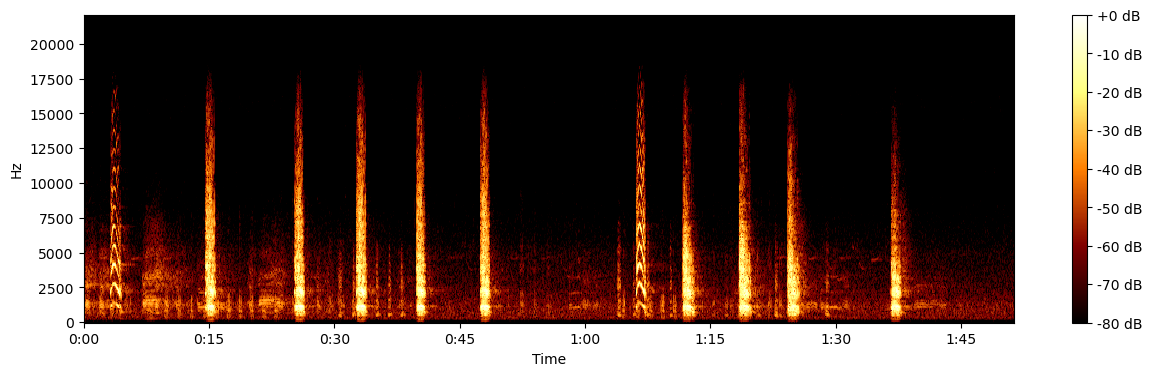

In [143]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(spec_db, sr=sr, x_axis='time', cmap = "afmhot", y_axis='hz')
plt.colorbar(format='%+2.0f dB')

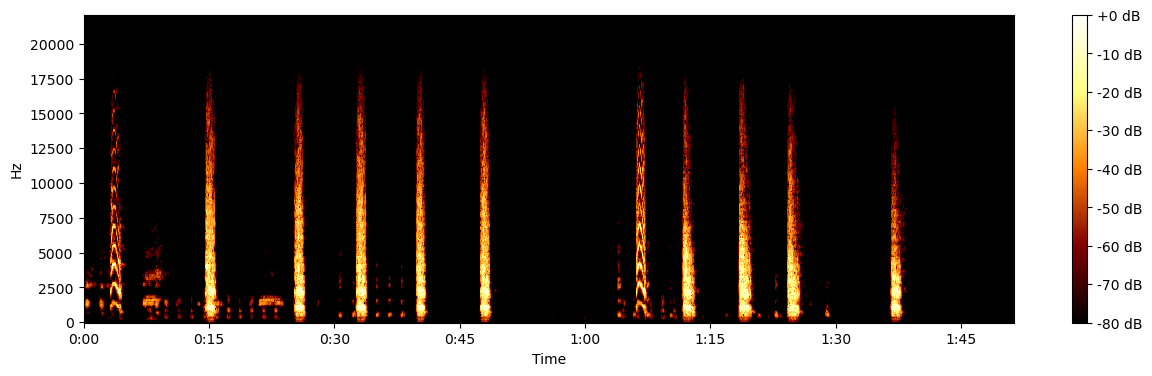

In [144]:
spec = librosa.stft(nr_track_data, n_fft=N_FFT, hop_length=(N_FFT // 8))
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=(15, 4))
librosa.display.specshow(spec_db, sr=sr, x_axis='time', cmap = "afmhot", y_axis='hz')
plt.colorbar(format='%+2.0f dB')

In [145]:
track_data, sr = librosa.load(track_paths[150], sr=None)

filtered_track_data = apply_butter_bandpass(track_data, lowcut, highcut, sr, order=5)

spec = librosa.stft(filtered_track_data, n_fft=N_FFT, hop_length=(N_FFT // 8))
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)

nr_track_data = nr.reduce_noise(
    y=filtered_track_data, 
    sr=sr, 
    stationary=True, 
    prop_decrease=prop_decrease,  
    freq_mask_smooth_hz=freq_mask_smooth_hz, 
    time_mask_smooth_ms = time_mask_smooth_ms,
    n_std_thresh_stationary=n_std_thresh,
    n_fft=N_FFT)

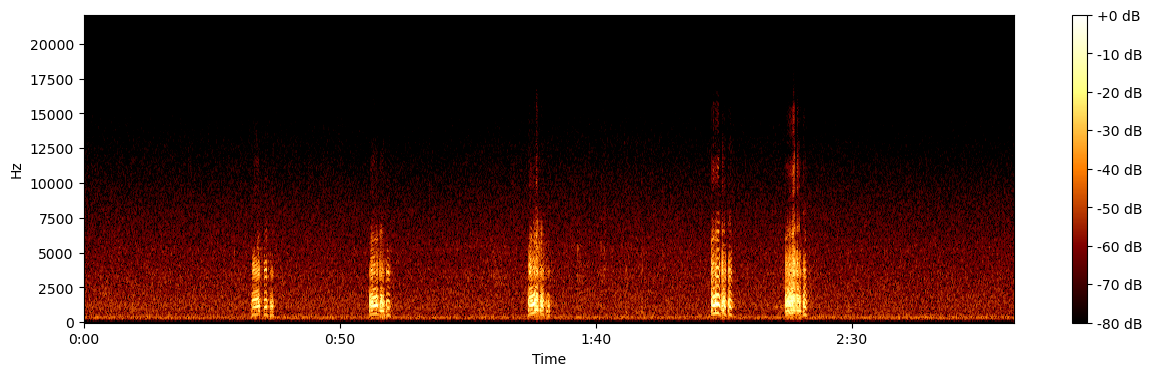

In [146]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(spec_db, sr=sr, x_axis='time', cmap = "afmhot", y_axis='hz')
plt.colorbar(format='%+2.0f dB')

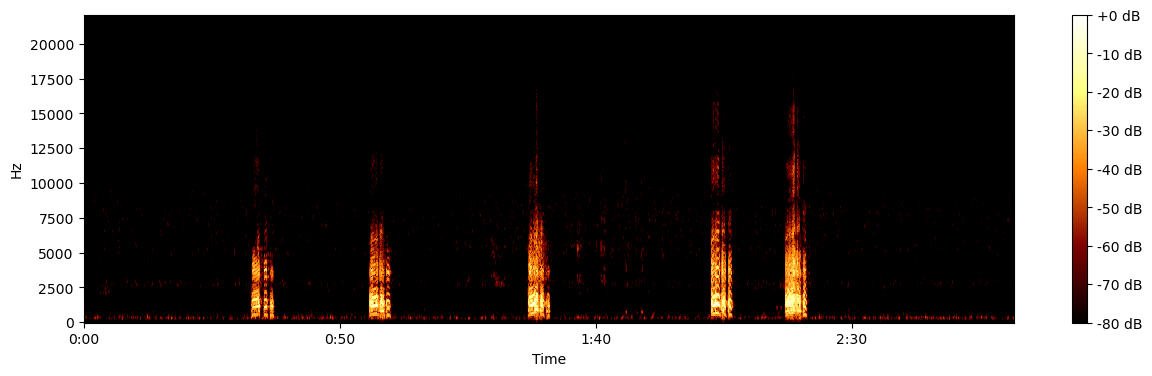

In [147]:
spec = librosa.stft(nr_track_data, n_fft=N_FFT, hop_length=(N_FFT // 8))
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=(15, 4))
librosa.display.specshow(spec_db, sr=sr, x_axis='time', cmap = "afmhot", y_axis='hz')
plt.colorbar(format='%+2.0f dB')

In [148]:
track_data, sr = librosa.load(track_paths[50], sr=None)

filtered_track_data = apply_butter_bandpass(track_data, lowcut, highcut, sr, order=5)

spec = librosa.stft(filtered_track_data, n_fft=N_FFT, hop_length=(N_FFT // 8))
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)

nr_track_data = nr.reduce_noise(
    y=filtered_track_data, 
    sr=sr, 
    stationary=True, 
    prop_decrease=prop_decrease,  
    freq_mask_smooth_hz=freq_mask_smooth_hz, 
    time_mask_smooth_ms=time_mask_smooth_ms,
    n_std_thresh_stationary=n_std_thresh,
    n_fft=N_FFT)

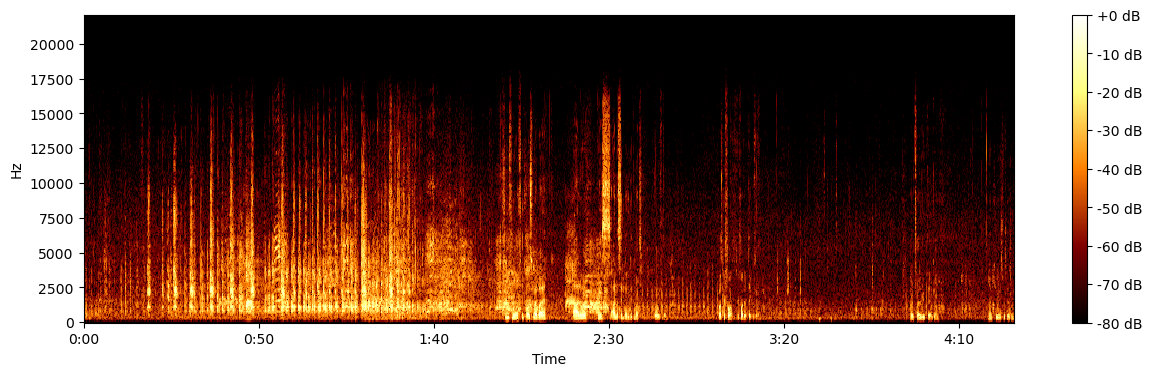

In [149]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(spec_db, sr=sr, x_axis='time', cmap = "afmhot", y_axis='hz')
plt.colorbar(format='%+2.0f dB')

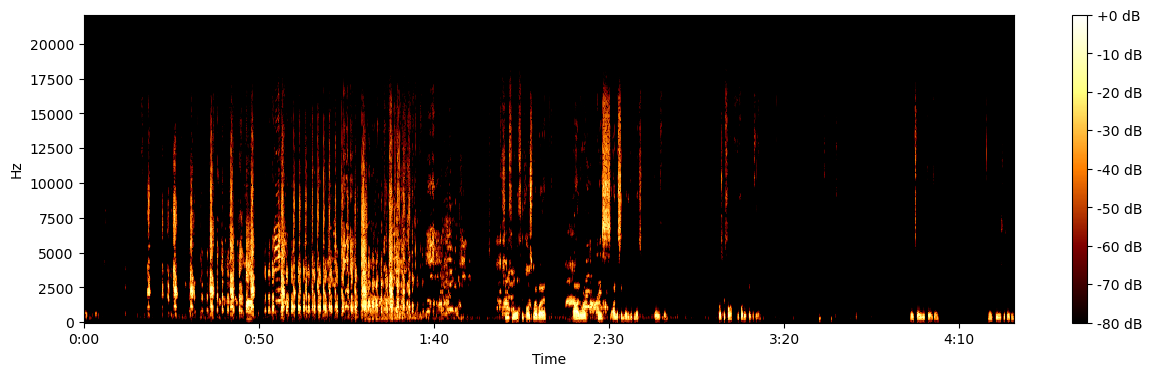

In [150]:
spec = librosa.stft(nr_track_data, n_fft=N_FFT, hop_length=(N_FFT // 8))
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=(15, 4))
librosa.display.specshow(spec_db, sr=sr, x_axis='time', cmap = "afmhot", y_axis='hz')
plt.colorbar(format='%+2.0f dB')

##### Loop through tracks and apply filter and noise reduction

In [151]:
master_df['same_track'] = master_df['Track ID'].eq(master_df['Track ID'].shift()) # create column indicating shift to next track

In [152]:
def read_track_file(track_id):
    if Path(DATAPATH+"/noise_reduced/"+track_id+"_noise_reduced.wav").is_file():
        track_data, sr = librosa.load(DATAPATH+"/noise_reduced/"+track_id+"_noise_reduced.wav", sr=None)
        return track_data, sr
    elif Path([track_path for track_path in track_paths if track_id in track_path][0]).is_file():
        track_data, sr = librosa.load([track_path for track_path in track_paths if track_id in track_path][0], sr=None)
        filtered_track_data = apply_butter_bandpass(track_data, lowcut, highcut, sr, order=5)
        nr_track_data = nr.reduce_noise(
            y=filtered_track_data, 
            sr=sr, 
            stationary=True, 
            prop_decrease=prop_decrease,  
            freq_mask_smooth_hz=freq_mask_smooth_hz, 
            time_mask_smooth_ms=time_mask_smooth_ms,
            n_std_thresh_stationary=n_std_thresh,
            n_fft=N_FFT)
        
        wavfile.write(DATAPATH+"/noise_reduced/"+track_id+"_noise_reduced.wav", sr, (nr_track_data * 32767).astype(np.int16)) # converting from 32bit float with amplitudes between -1 and 1 to 16bit in with a max amplitude of 32767 https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
        return track_data, sr
    else:
        print("unable to load track "+track_id)
        return

In [153]:
# Write selections to files
not_found_count = 0
snrs = []
track_lengths = []
clip_lengths = []
processed_clips = []

for index, row in master_df.iterrows():
    track_id = row["Track ID"]
    if row["Clip ID"] in processed_clips:
        continue
    
    if not row['same_track']:
        track_data, sr = read_track_file(track_id)

        if compute_snr(track_data) == 0:
            print(track_id+"contains a flat signal")
        snrs.append(compute_snr(track_data))
        track_lengths.append(len(track_data)/sr)

    if len(track_data) == 0: 
        print(track_id+" track size 0")
        not_found_count += 1
        continue

    i_start = int(max((row["Begin Time (s)"] - PADDING_SECS) * sr, 0))
    i_end = int(min((row["End Time (s)"] + PADDING_SECS) * sr, len(track_data)))

    if len(track_data[i_start:i_end]) == 0:
        not_found_count += 1
        print(track_id+" selection size 0")
        continue

    if not Path(OUTPATH+f"/{track_id}_{row['Clip ID']}_{row['Goose ID']}_{row['Call Type']}.wav").is_file():
        wavfile.write(OUTPATH+f"/{track_id}_{row['Clip ID']}_{row['Goose ID']}_{row['Call Type']}.wav", sr, (track_data[i_start:i_end] * 32767).astype(np.int16))

    processed_clips.append(row["Clip ID"])
    clip_lengths.append(len(track_data[i_start:i_end])/sr)
        
print(not_found_count)

0


Inspect track lengths, goose IDs and snrs

Text(0, 0.5, 'Spectral SNR')

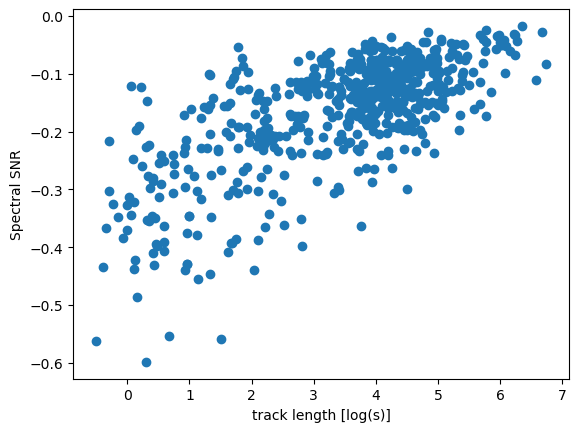

In [154]:
plt.scatter(np.log(track_lengths), snrs)
plt.xlabel("track length [log(s)]")
plt.ylabel("Spectral SNR")

Text(0, 0.5, 'count')

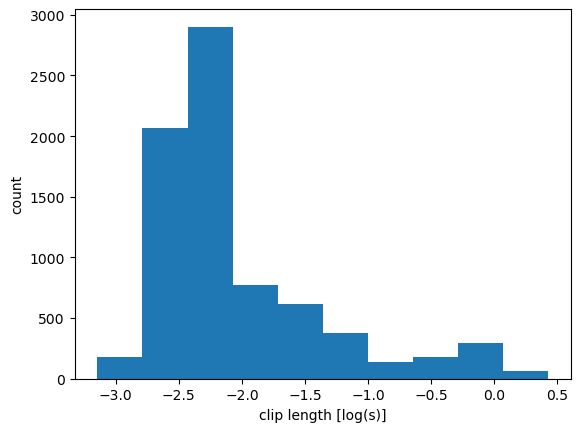

In [155]:
plt.hist(np.log(clip_lengths))
plt.xlabel("clip length [log(s)]")
plt.ylabel("count")

[]

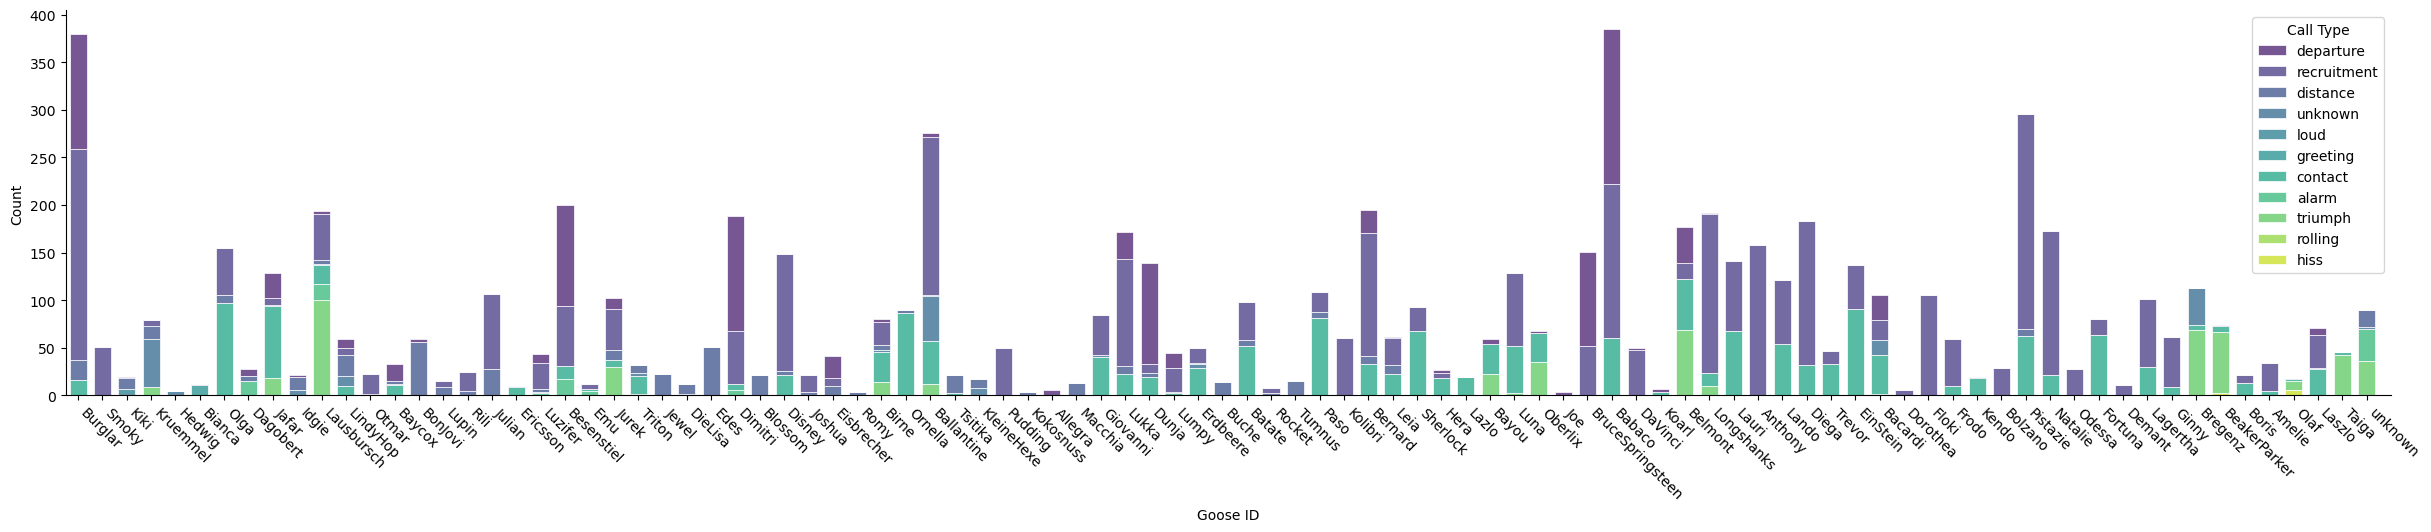

In [156]:
# only plot occurences above count of one
counts = master_df["Goose ID"].value_counts()
filtered_df = master_df[master_df["Goose ID"].isin(counts[counts > 3].index)]

f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

sns.histplot(
    filtered_df,
    x="Goose ID",
    multiple="stack",
    hue="Call Type",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
)
plt.xticks(rotation=-45, ha='left')
plt.xlim(left=-0.5, right=len(filtered_df["Goose ID"].unique()))
plt.plot()